In [745]:
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms

In [127]:
path = Path('data')
bs = 8
size = 64
imagenet_stats = np.array([[0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225]])

# Define image transforms.
tfms = transforms.Compose([transforms.Resize(size),
                           transforms.ToTensor(),
                           transforms.Normalize(*imagenet_stats)])

In [735]:
ds = datasets.ImageFolder(path, transform=tfms)

# Split into train and validation.
train_pct = .1
train_size = int(len(ds)*train_pct)
val_size = len(ds) - train_size
train_ds, val_ds = random_split(ds, [train_size, val_size])

In [736]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)
len(train_ds), len(val_ds)

(20, 180)

In [737]:
print(ds.class_to_idx)

{'horse': 0, 'zebra': 1}


In [738]:
x_tmp, y_tmp = next(iter(train_dl))
x_tmp.shape, y_tmp.shape

(torch.Size([8, 3, 64, 64]), torch.Size([8]))

In [739]:
class KNet(nn.Module):
    
    def __init__(self, k):
        """
        Parameters
        -----------
        k: int
            Number of distinct final layers to use.
        """
        super().__init__()
        resnet = models.resnet34(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        self.linear_layers = nn.ModuleList([nn.Linear(512, 1, bias=False) 
                                            for i in range(k)])
        
        self.k = k
        self.n_layers = len(list(self.parameters()))
        self.freeze()
            
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.shape[0], -1)

        outputs = []
        for layer in self.linear_layers:
            outputs.append(torch.sigmoid(layer(x)))
            
#         return outputs
        # AVG SOFT PREDS FIRST, OR CALC LOSS ON EACH MODEL AND THEN AVG?
        # IF SEPARATE, SHOULD WE AVG HARD PREDS OR SOFT?
        final_pred = torch.mean(torch.cat(outputs, dim=1), dim=1)
        return final_pred, outputs
    
    def k_weights(self):
        """Parameters for trainable layers following resnet34.
        
        IF USING BIAS IN LINEAR LAYERS, MUST USE n*2.
        """
        return list(self.parameters())[-self.k:]
    
    def freeze(self, n=None):
        """By default, freeze all but the last layer (i.e. freeze all the 
        pre-trained layers). Passing in a larger value of n will unfreeze the
        last n layers.
        
        IF USING BIAS IN LINEAR LAYERS, MUST USE n*2.
        """
        if n is None:
            n = self.k
        for i, p in enumerate(self.parameters()):
            if i < self.n_layers - n:
                p.requires_grad = False
            else:
                p.requires_grad = True
                
    def unfreeze(self, n=None):
        """By default, unfreeze all layers. If n is passed in, unfreeze the 
        last n layers. This is just a helper function that may be less
        confusing than using freeze() to unfreeze.
        """
        if n is None:
            self.freeze(self.n_layers)
        else:
            self.freeze(n)
            
    def dims(self):
        """Get shape of each layer's weights."""
        return [p.shape for p in self.parameters()]
    
    def trainable(self):
        """Check which layers are trainable."""
        return [p.requires_grad for p in self.parameters()]
    
    def layer_stats(self):
        """Check mean and standard deviation of each layer's weights."""
        return [(round(p.data.mean().item(), 3), 
                 round(p.data.std().item(), 3))
                 for p in self.parameters()]

In [824]:
def parameter_loss(layers, loss=F.mse_loss, scale=standard_scale):
    """Compute similarity loss to penalize layers learning similar weights.
    
    Parameters
    -----------
    layers: list
        Parameters for the layers that follow the pre-trained portion of the 
        model. Due to the bias terms, the list is actually k*2 items long.
    criterion: function
        Use to calculate loss.
    scale: function
        Use to scale weights. Options: torch.sigmoid, F.tanh, 
        nn.Softmax(dim=0) (softmax requires explicit dimension),
        minmax_scale, standard_scale.
    """
    weights = [scale(layer) for layer in layers]
    total_loss = 0
    for i, pair in enumerate(combinations(weights, 2)):
        total_loss += loss(*pair)

    # Return inverse of mean because we want a similarity measure.
    return (i / total_loss)

In [741]:
def standard_scale(x):
    """Standardize using mean and standard deviation.
    
    Parameters
    -----------
    x: tensor
    """
    return (x - x.mean()) / x.std()

In [742]:
def minmax_scale(x):
    """Standardize using mean and standard deviation.
    
    Parameters
    -----------
    x: tensor
    """
    x_max = x.max()
    x_min = x.min()
    return (x - x_min) / (x_max - x_min)

In [829]:
def correlation(x, y):
    """Pearson correlation coefficient of two tensors."""
    x, y = x.flatten(), y.flatten()
    x_sub = x - x.mean()
    y_sub = y - y.mean()
    n = x_sub @ y_sub
    d = torch.sqrt(torch.sum(x_sub**2) * torch.sum(y_sub**2))
    return n/d

In [832]:
def inverse_corr(x, y):
    return torch.abs(1 / correlation(x, y))

In [861]:
def train(epochs, lr, train_dl, val_dl, alpha=.1, beta=.1, model=None, k=3, 
          loss=F.mse_loss):
    if not model:
        model = KNet(k)
    optim = torch.optim.Adam(model.parameters(), lr)
    
    # Store stats to return at end.
    losses = defaultdict(list)
    
    # Begin training loop.
    for epoch in range(epochs):
        model.train()
        e_loss_total = 0
        e_loss_main = 0
        e_loss_output = 0
        e_loss_weight = 0
        e_correct = 0
        e_total = 0
        for x, y in train_dl:
            x = x.to(device)
            y = y.float().to(device)
            batch_size = x.shape[0]
            
            # y_hat is tensor of soft predictions from averaging output of 
            # all k layers. Outputs contains soft predictions for each layer.
            optim.zero_grad()
            y_hat, outputs = model(x)
#             main_loss = F.binary_cross_entropy(y_hat, y)
#             output_loss = torch.tensor([F.binary_cross_entropy(out, y) 
#                                         for out in outputs], 
#                                         requires_grad=True).sum()
            weight_loss = parameter_loss(model.k_weights(), loss=inverse_corr,
                                         scale=minmax_scale)
#             total_loss = main_loss + alpha*output_loss + beta*weight_loss
#             total_loss.backward()
#             optim.step()

            # TESTING
            main_loss, output_loss, total_loss = 0, 0, 0
#             total_loss = main_loss + alpha*output_loss + beta*weight_loss
            print('\nbefore step', model.layer_stats()[-4:])  
#             total_loss = main_loss + beta*weight_loss
            weight_loss.backward()
            optim.step()
            print('after step', model.layer_stats()[-4:])  
            # END TESTING
            
            # Update stats at end of batch.
            e_loss_total += total_loss
            e_loss_main += main_loss
            e_loss_output += output_loss
            e_loss_weight += weight_loss
            e_correct += torch.sum(torch.round(y_hat).eq(y)).item()
            e_total += batch_size
            
        # Calculate validation metrics.
        val_loss, val_acc = val_metrics(model, val_dl)
        train_acc = e_correct / e_total
            
        # Update stats at end of epoch.    
        losses['total'].append(e_loss_total)
        losses['main'].append(e_loss_main)
        losses['output'].append(e_loss_output)
        losses['weight'].append(e_loss_weight)
        
        print(f'\nEpoch [{epoch+1}/{epochs}]'
              f'\nMain loss: {e_loss_main:.4f}'
              f'\tOutput losses: {e_loss_output:.4f}'
              f'\tWeight loss: {e_loss_weight:.4f}'
              f'\tTotal loss: {e_loss_total:.4f}'
              f'\tTrain acc: {train_acc:.4f}'
              f'\nValidation loss: {val_loss:.4f}'
              f'\tValidation acc: {val_acc:.4f}')

    return dict(model=model, losses=losses)

In [862]:
def val_metrics(model, val_dl):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total = 0
        correct = 0
        for x, y, in val_dl:
            x, y = x.to(device), y.float().to(device)
            y_hat, _ = model(x)
            loss = F.binary_cross_entropy(y_hat, y, reduction='sum')
            total_loss += loss
            total += x.shape[0]
            correct += torch.sum(torch.round(y_hat).eq(y)).item()
    return total_loss / total, correct / total

In [863]:
ngpu = 1
device = torch.device('cuda:0' if torch.cuda.is_available() and ngpu > 0 
                      else 'cpu')

In [864]:
# model = KNet(3)

In [866]:
# NOTICE BETA=1 ATM.
lr = 3
output = train(10, lr, train_dl, val_dl, alpha=.1, beta=1, k=3)


before step [(0.136, 0.047), (-0.001, 0.026), (-0.003, 0.026), (-0.002, 0.026)]
after step [(0.136, 0.047), (0.116, 3.002), (-0.109, 3.0), (-0.19, 2.997)]

before step [(0.136, 0.047), (0.116, 3.002), (-0.109, 3.0), (-0.19, 2.997)]
after step [(0.136, 0.047), (0.195, 5.013), (-0.213, 4.992), (-0.33, 4.996)]

before step [(0.136, 0.047), (0.195, 5.013), (-0.213, 4.992), (-0.33, 4.996)]
after step [(0.136, 0.047), (0.256, 6.574), (-0.288, 6.538), (-0.435, 6.544)]

Epoch [1/10]
Main loss: 0.0000	Output losses: 0.0000	Weight loss: 0.1056	Total loss: 0.0000	Train acc: 0.7000
Validation loss: 1.3865	Validation acc: 0.4000

before step [(0.136, 0.047), (0.256, 6.574), (-0.288, 6.538), (-0.435, 6.544)]
after step [(0.136, 0.047), (0.307, 7.859), (-0.348, 7.805), (-0.52, 7.809)]

before step [(0.136, 0.047), (0.307, 7.859), (-0.348, 7.805), (-0.52, 7.809)]
after step [(0.136, 0.047), (0.351, 8.955), (-0.397, 8.877), (-0.59, 8.878)]

before step [(0.136, 0.047), (0.351, 8.955), (-0.397, 8.877),

In [867]:
val_metrics(output['model'], val_dl)

(tensor(2.4718), 0.4222222222222222)

In [868]:
def plot_losses(output):
    fig, ax = plt.subplots()
    for k, v in output['losses'].items():
        ax.plot(v, label=k)
    plt.legend()
    plt.show()

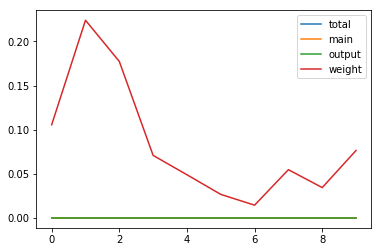

In [872]:
plot_losses(output)

In [870]:
output['losses']

defaultdict(list,
            {'total': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             'main': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             'output': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             'weight': [tensor(0.1056, grad_fn=<AddBackward0>),
              tensor(0.2241, grad_fn=<AddBackward0>),
              tensor(0.1774, grad_fn=<AddBackward0>),
              tensor(0.0709, grad_fn=<AddBackward0>),
              tensor(0.0490, grad_fn=<AddBackward0>),
              tensor(0.0267, grad_fn=<AddBackward0>),
              tensor(0.0145, grad_fn=<AddBackward0>),
              tensor(0.0547, grad_fn=<AddBackward0>),
              tensor(0.0344, grad_fn=<AddBackward0>),
              tensor(0.0764, grad_fn=<AddBackward0>)]})

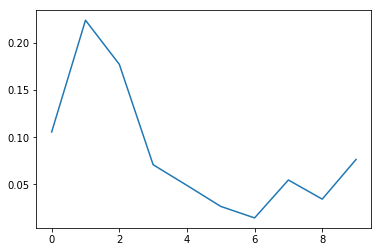

In [871]:
fig, ax = plt.subplots()
ax.plot(output['losses']['weight'])
plt.show()

In [ ]:
model.layer_stats

In [833]:
tmp = parameter_loss(model.k_weights(), scale=nn.Softmax(dim=1))
tmp

tensor(1.3414e+08, grad_fn=<MulBackward0>)

In [834]:
parameter_loss(model.k_weights(), loss=inverse_corr, scale=lambda x: x)

tensor(0.0082, grad_fn=<MulBackward0>)

In [424]:
y_tmp = model(x_tmp)
len(y_tmp), y_tmp[0].shape, y_tmp[1]

(2, torch.Size([8]), [tensor([[0.4032],
          [0.7646],
          [0.4726],
          [0.9294],
          [0.7303],
          [0.6757],
          [0.3103],
          [0.5416]], grad_fn=<SigmoidBackward>), tensor([[0.2480],
          [0.4061],
          [0.4896],
          [0.2512],
          [0.6784],
          [0.2211],
          [0.3156],
          [0.6015]], grad_fn=<SigmoidBackward>), tensor([[0.8572],
          [0.4351],
          [0.5597],
          [0.2690],
          [0.4812],
          [0.6606],
          [0.4983],
          [0.5077]], grad_fn=<SigmoidBackward>)])

In [675]:
torch.round(y_tmp[0])

tensor([1., 1., 1., 0., 1., 1., 0., 1.], grad_fn=<RoundBackward>)

In [676]:
y_tmp[0]

tensor([0.5028, 0.5352, 0.5073, 0.4832, 0.6300, 0.5191, 0.3747, 0.5503],
       grad_fn=<MeanBackward0>)

In [130]:
list(path.iterdir())

[PosixPath('data/zebra'), PosixPath('data/horse')]